## Abstract

#### The Libraries Required :

In [4]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import gym
from IPython.display import Image

#### Imported environment MountainCar from Gym and stored in env

![title](images/mountain_car.png)

In [7]:
env = gym.make('MountainCar-v0')

### States, the Actions and the Size of the Q-table?

#### Size of action space

In [8]:
env.action_space.n

3

#### Limits of state space

In [9]:
env.observation_space.high

array([0.6 , 0.07], dtype=float32)

In [10]:
env.observation_space.low

array([-1.2 , -0.07], dtype=float32)

#### States 

Position = -1.2 to +0.6   
Velocity = -0.07 to +0.07

#### Actions 
PushLeft, PushRight, NoPush

#### Size of Q-table :

(0.6+1.2+0.1)*10 = 19   
(0.07+0.07+0.01) = 15   
action space = 3

Q table size = (19*15*3)


#### Resets the state of the environment and returns an initial observation

In [12]:
# Random position from -0.6 to -0.4 with no velocity is the starting state
print(env.reset()) ###

[-0.49088448  0.        ]


#### Run one timestep of the environment's dynamics

In [16]:
print(env.step(1)) # Return new state,reward,done,info

(array([-0.49330678, -0.00096165]), -1.0, False, {})


### Rewards

Rewards are -1 for each time step, until the goal position of 0.5 is reached.

#### Function defined for Q learning Code

In [89]:
def QLearning_old(env, learning, discount, epsilon, min_eps,episodes):
    # Converting observation space to integers multiplying with 10 and 100 for position and velocity respectively
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initial Values for q table within range -1 to 1 randomly with q table of dim 19*15*3
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    # List variables to store rewards list avg rewards and car positions
    reward_list = []
    ave_reward_list = []
    car_position = []
    
    # Calculating  episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    for i in range(episodes):
        done = False
        tot_reward, reward = 0,0
        #env is reseted for every new epsiode
        state = env.reset()

        #Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
        
        while done != True:
            # render only last twenty episodes
            
#             if i >= (episodes - 20):
#                 env.render()

            # Determine next action - epsilon greedy strategy    
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
            
            # Get next state and reward
            state2, reward, done, info = env.step(action) 
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
            else: # Adjust Q value for current state
                delta = learning*(reward + 
                                 discount*(np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action]))
                Q[state_adj[0], state_adj[1],action] += delta
            
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
            
            # Decay epsilon
            if epsilon > min_eps:
                epsilon -= reduction

            
              
            
            reward_list.append(tot_reward)
        
        car_position+=[state2[0]]
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
            
    env.close()
    
    return car_position
        
    

### Below is the baseline performance of the Mountain Car  using some standard values for alpha,gamma,epsilon and number of episodes

In [90]:
rewards = QLearning_old(env, 0.7, 0.8, 1.0, 0,5000)

Episode 100 Average Reward: -100.5
Episode 200 Average Reward: -100.16473422677308
Episode 300 Average Reward: -99.05610661783408
Episode 400 Average Reward: -97.4229809791082
Episode 500 Average Reward: -98.4549602665983
Episode 600 Average Reward: -98.03948046593135
Episode 700 Average Reward: -95.51867396270521
Episode 800 Average Reward: -94.7075613151976
Episode 900 Average Reward: -99.67767676767677
Episode 1000 Average Reward: -83.66003296502045
Episode 1100 Average Reward: -87.81965116279069
Episode 1200 Average Reward: -85.73938384679434
Episode 1300 Average Reward: -86.63105135916032
Episode 1400 Average Reward: -88.194016003711
Episode 1500 Average Reward: -97.36867557589309
Episode 1600 Average Reward: -100.09641278135048
Episode 1700 Average Reward: -98.12599114406343
Episode 1800 Average Reward: -94.35896468050687
Episode 1900 Average Reward: -96.35798177700532
Episode 2000 Average Reward: -84.44526341227646
Episode 2100 Average Reward: -78.41179497073767
Episode 2200 Ave

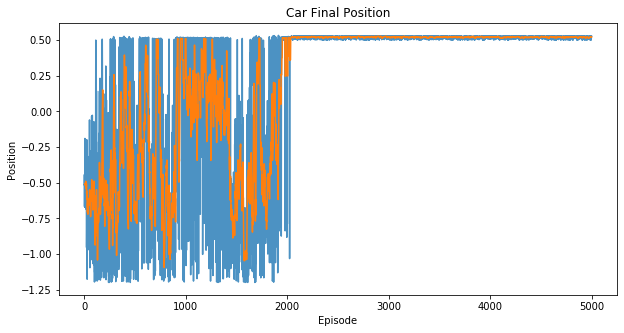

In [91]:
plt.figure(2, figsize=[10,5])
p = pd.Series(rewards)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

##### While using baseline parameters the car is reaching the target consistently after 2000 episodes 

In [185]:
def QLearning_new_pf(env, learning, discount, epsilon, min_eps, decay_rate,episodes):
    # Converting observation space to integers multiplying with 10 and 100 for position and velocity respectively
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initial Values for q table within range -1 to 1 randomly with q table of dim 19*15*3
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    # List variables to store rewards list avg rewards and car positions
    reward_list = []
    ave_reward_list = []
    car_position = []
    
    # Calculating  episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    for i in range(episodes):
        done = False
        tot_reward, reward = 0,0
        #env is reseted for every new epsiode
        state = env.reset()

        #Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
        
        while done != True:
            # render only last twenty episodes
            
#             if i >= (episodes - 20):
#                 env.render()

            # Determine next action - epsilon greedy strategy    
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
            
            # Get next state and reward
            state2, reward, done, info = env.step(action) 
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                
            else: # Adjust Q value for current state
                delta = learning*(reward + 
                                 discount*(np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action]))
                Q[state_adj[0], state_adj[1],action] += delta
            
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
            
            # Decay epsilon
#             if epsilon > min_eps:
#                 epsilon -= reduction

            #As Exploration should be more in the beginning once reaches target exploration should be minimum
            epsilon = min_eps + (epsilon - min_eps)*np.exp(-decay_rate*i)   
            
            reward_list.append(tot_reward)
        
        car_position+=[state2[0]]
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
            
    env.close()
    
    return car_position
        
    

In [186]:
rewards_new_pf = QLearning_new_pf(env, 0.7, 0.8, 1.0, 0, 0.01,5000)

Episode 100 Average Reward: -100.5
Episode 200 Average Reward: -100.48522278341751
Episode 300 Average Reward: -99.40270393437642
Episode 400 Average Reward: -99.398551458671
Episode 500 Average Reward: -96.60519847288322
Episode 600 Average Reward: -99.83246864453734
Episode 700 Average Reward: -96.02607458912769
Episode 800 Average Reward: -93.75852564449008
Episode 900 Average Reward: -97.23905043279946
Episode 1000 Average Reward: -93.50191068893984
Episode 1100 Average Reward: -89.6250573131591
Episode 1200 Average Reward: -83.4297556993029
Episode 1300 Average Reward: -81.26326569800935
Episode 1400 Average Reward: -86.98481950753047
Episode 1500 Average Reward: -97.5152947286419
Episode 1600 Average Reward: -97.61461725332093
Episode 1700 Average Reward: -95.00717536813923
Episode 1800 Average Reward: -95.74106106950744
Episode 1900 Average Reward: -95.93104535659852
Episode 2000 Average Reward: -91.93553792872305
Episode 2100 Average Reward: -92.02893854748604
Episode 2200 Aver

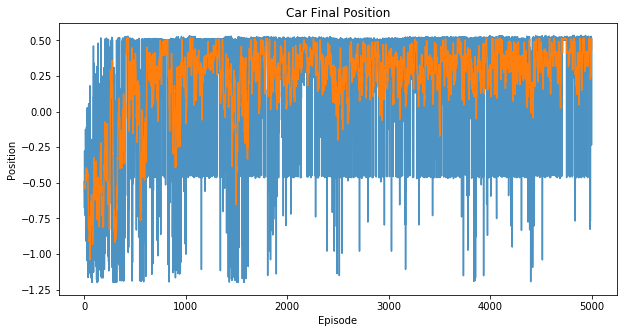

In [187]:
plt.figure(2, figsize=[10,5])
p = pd.Series(rewards_new_pf)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

We will use different epsilon reduction function where exploration is given more priority than exploitation

In [176]:
def QLearning_new(env, learning, discount, epsilon, min_eps, decay_rate,episodes):
    # Converting observation space to integers multiplying with 10 and 100 for position and velocity respectively
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initial Values for q table within range -1 to 1 randomly with q table of dim 19*15*3
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    # List variables to store rewards list avg rewards and car positions
    reward_list = []
    ave_reward_list = []
    car_position = []
    
    # Calculating  episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    for i in range(episodes):
        done = False
        tot_reward, reward = 0,0
        #env is reseted for every new epsiode
        state = env.reset()

        #Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
        
        while done != True:
            # render only last twenty episodes
            
#             if i >= (episodes - 20):
#                 env.render()

            # Determine next action - epsilon greedy strategy    
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
            
            # Get next state and reward
            state2, reward, done, info = env.step(action) 
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                
            else: # Adjust Q value for current state
                delta = learning*(reward + 
                                 discount*(np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action]))
                Q[state_adj[0], state_adj[1],action] += delta
            
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
            
            # Decay epsilon
#             if epsilon > min_eps:
#                 epsilon -= reduction

            #As Exploration should be more in the beginning once reaches target exploration should be minimum
            epsilon = min_eps + (epsilon - min_eps)*np.exp(-decay_rate*((episodes/2)-i))   
            
            reward_list.append(tot_reward)
        
        car_position+=[state2[0]]
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
            
    env.close()
    
    return car_position
        
    

In [177]:
rewards_new = QLearning_new(env, 0.7, 0.8, 1.0, 0, 0.01,5000)

Episode 100 Average Reward: -100.5
Episode 200 Average Reward: -100.5
Episode 300 Average Reward: -100.25446249498596
Episode 400 Average Reward: -94.93867166577397
Episode 500 Average Reward: -91.47552643369175
Episode 600 Average Reward: -72.69889789977127
Episode 700 Average Reward: -72.47931873479318
Episode 800 Average Reward: -72.4721507544677
Episode 900 Average Reward: -72.73839867017593
Episode 1000 Average Reward: -72.68110918544194
Episode 1100 Average Reward: -72.91092529887361
Episode 1200 Average Reward: -73.17679862306369
Episode 1300 Average Reward: -72.54708987359355
Episode 1400 Average Reward: -72.40510821908275
Episode 1500 Average Reward: -72.56469199249948
Episode 1600 Average Reward: -72.61212878157092
Episode 1700 Average Reward: -72.56277777777778
Episode 1800 Average Reward: -72.69108677571388
Episode 1900 Average Reward: -72.64493758668516
Episode 2000 Average Reward: -72.64884172562076
Episode 2100 Average Reward: -72.83751815729404
Episode 2200 Average Rewa

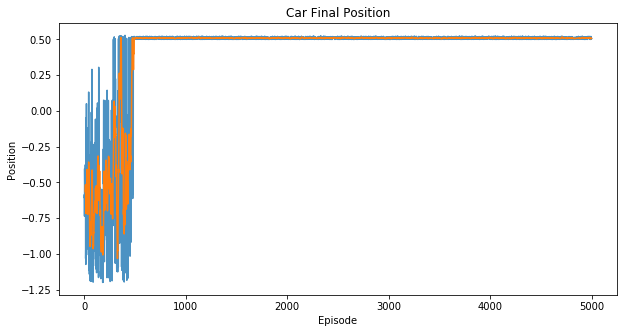

In [178]:
plt.figure(2, figsize=[10,5])
p = pd.Series(rewards_new)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

##### Here after While using baseline parameters the car is reaching the target consistently after 700 episodes 

### Choosing alpha and gamma in the equation!!!
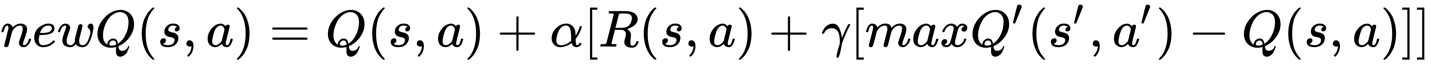




The learning rate, set between 0 and 1. Setting it to 0 means that the Q-values are never updated, hence nothing is learned. Setting a high value such as 0.9 means that learning can occur quickly.

The discount factor, also set between 0 and 1. This models the fact that future rewards are worth less than immediate rewards. Mathematically, the discount factor needs to be set less than 0 for the algorithm to converge

We will experiment with other values for alpha and gamma and observe how did it change the baseline performance?

In [143]:
rewards_new_ht = QLearning_new(env, 0.6, 0.7, 1.0, 0, 0.01,5000)

Episode 100 Average Reward: -100.5
Episode 200 Average Reward: -100.37230846269404
Episode 300 Average Reward: -98.00190731481004
Episode 400 Average Reward: -99.89849889179932
Episode 500 Average Reward: -95.01149240966431
Episode 600 Average Reward: -93.88407608695653
Episode 700 Average Reward: -95.12866527800033
Episode 800 Average Reward: -94.1176851651911
Episode 900 Average Reward: -92.78026905829596
Episode 1000 Average Reward: -85.9633784425451
Episode 1100 Average Reward: -88.67476538660833
Episode 1200 Average Reward: -91.2591147285093
Episode 1300 Average Reward: -92.52532688715526
Episode 1400 Average Reward: -91.19909350344133
Episode 1500 Average Reward: -92.35475875743556
Episode 1600 Average Reward: -79.97001605136437
Episode 1700 Average Reward: -79.13956185567011
Episode 1800 Average Reward: -77.14550819672131
Episode 1900 Average Reward: -79.46820440932841
Episode 2000 Average Reward: -77.40941698187035
Episode 2100 Average Reward: -75.83482800160621
Episode 2200 Av

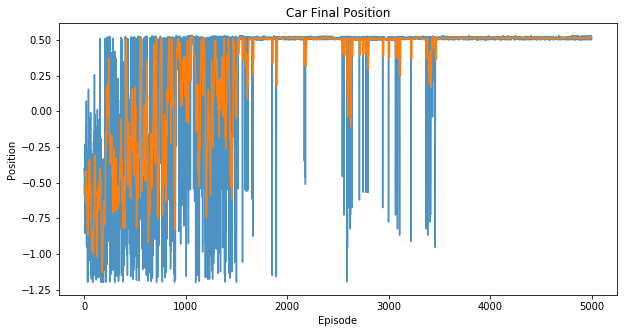

In [144]:
plt.figure(2, figsize=[10,5])
p = pd.Series(rewards_new_ht)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

In [ ]:
Performance of the model has increased when changing learning rate to 0.9 and discount to 0.6

### Try a policy other than maxQ(s', a'). How did it change the baseline performance?

In [180]:
def QLearning_new_policy(env, learning, discount, epsilon, min_eps, decay_rate,episodes):
    # Converting observation space to integers multiplying with 10 and 100 for position and velocity respectively
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initial Values for q table within range -1 to 1 randomly with q table of dim 19*15*3
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    # List variables to store rewards list avg rewards and car positions
    reward_list = []
    ave_reward_list = []
    car_position = []
    
    # Calculating  episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    for i in range(episodes):
        done = False
        tot_reward, reward = 0,0
        #env is reseted for every new epsiode
        state = env.reset()

        #Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
        
        while done != True:
            # render only last twenty episodes
            
#             if i >= (episodes - 20):
#                 env.render()

            # Determine next action - epsilon greedy strategy    
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
            
            # Get next state and reward
            state2, reward, done, info = env.step(action) 
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
            else: # Adjust Q value for current state
                delta = learning*(reward + 
                                 discount*(np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]+1) - 
                                 Q[state_adj[0], state_adj[1],action]))
                Q[state_adj[0], state_adj[1],action] += delta
#                 print(Q[state2_adj[0],state2_adj[1]])
            
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
            
            # Decay epsilon
#             if epsilon > min_eps:
#                 epsilon -= reduction

            #As Exploration should be more in the beginning once reaches target exploration should be minimum
            epsilon = min_eps + (epsilon - min_eps)*np.exp(-decay_rate*((episodes/2)-i))   
            
            reward_list.append(tot_reward)
        
        car_position+=[state2[0]]
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
            
    env.close()
    
    return car_position
        
    

In [181]:
rewards_NR = QLearning_new_policy(env, 0.7, 0.8, 1.0, 0, 0.01,5000)

Episode 100 Average Reward: -100.34894554926615
Episode 200 Average Reward: -100.30381840048106
Episode 300 Average Reward: -99.85742354778579
Episode 400 Average Reward: -99.54879838097648
Episode 500 Average Reward: -96.58926604060647
Episode 600 Average Reward: -98.06548171045853
Episode 700 Average Reward: -97.29141311697093
Episode 800 Average Reward: -95.07832130446404
Episode 900 Average Reward: -89.39898151856725
Episode 1000 Average Reward: -86.25115370962017
Episode 1100 Average Reward: -93.92726781857452
Episode 1200 Average Reward: -96.00563929587857
Episode 1300 Average Reward: -97.96302399835204
Episode 1400 Average Reward: -88.6403024134923
Episode 1500 Average Reward: -80.52514358647096
Episode 1600 Average Reward: -79.4071899262739
Episode 1700 Average Reward: -80.04679187231588
Episode 1800 Average Reward: -78.50992426220945
Episode 1900 Average Reward: -77.32258492569002
Episode 2000 Average Reward: -81.25208491281273
Episode 2100 Average Reward: -78.63232739205971
E

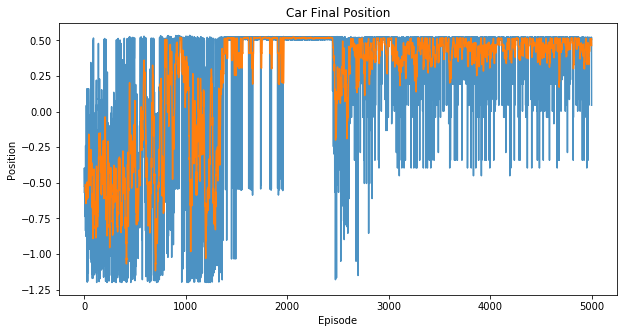

In [182]:
plt.figure(2, figsize=[10,5])
p = pd.Series(rewards_NR)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

### How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode?

### What is the average number of steps taken per episode?

### Does Q-learning use value-based or policy-based iteration?

### What is meant by expected lifetime value in the Bellman equation?

Copyright 2020 Satya Ikyath Varma Dantuluri

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.